In [1]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs --break-system-packages
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO --break-system-packages

In [2]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO

In [3]:
# !pip install -e ../../objFuncs
# !pip install -e ../../pyBO

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from copy import deepcopy as copy

/home/devuser/.local/lib/python3.9/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [5]:
import objFuncs
from objFuncs import VM
from objFuncs import residuals
from objFuncs.util import plot_obj_history, plot_multi_obj_history
from objFuncs import flame_utils_kilean as flame_utils

objFuncs version: 1.0.3. updated on 2024-01-25


In [6]:
from pyBO import pyBO

n_init = 32
batch_size = 8
n_loop = 3
budget = n_init+n_loop*batch_size
print(budget)

pyBO version: 1.0.0. updated on 2023-12-14
56


In [7]:
decision_CSETs=[
    'FS2_BTS:PSC2_D3930:I_CSET',
    'FS2_BTS:PSC2_D3945:I_CSET',
#     'FS2_BTS:PSC2_D3962:I_CSET',
]
objective_goal = { 
    'FS2_BTS:BPM_D3958:XPOS_RD' : 0.0,
    'FS2_BTS:BPM_D4006:XPOS_RD' : 0.0,
}
objective_norm = {pv:1.0 for pv in objective_goal.keys()}
objective_weight = {pv:1.0 for pv in objective_goal.keys()}
objective_RDs = list(objective_goal.keys())

n_condition = 3
conditional_SETs = {
    'FS2_BTS:PSQ_D3950:I_CSET':[70,100, 70],
    'FS2_BTS:PSQ_D3955:I_CSET':[70, 70,100],
}

In [8]:
fm_vms = []
for i in range(n_condition):
    fm_vm = flame_utils.VM(
            latfile = "test_FS2a_20231130_040841_read.lat",
            decision_CSETs = decision_CSETs,
            objective_RDs  = objective_RDs,
            conditional_SETs = {key:val[i] for key, val in conditional_SETs.items()},
        )
    m0 = copy(fm_vm.fm.bmstate.moment0)
    m0[0] = 2.
    fm_vm.fm.bmstate.moment0 = m0
    fm_vms.append(fm_vm)

'test_FS2a_20231130_040841_read.lat' does not exist in current working path.
FLAME lattice file found from lat repo: 
    /home/devuser/Desktop/WinHome/GitHub/objFuncs/objFuncs/FLAME_lat/test_FS2a_20231130_040841_read.lat
'test_FS2a_20231130_040841_read.lat' does not exist in current working path.
FLAME lattice file found from lat repo: 
    /home/devuser/Desktop/WinHome/GitHub/objFuncs/objFuncs/FLAME_lat/test_FS2a_20231130_040841_read.lat
'test_FS2a_20231130_040841_read.lat' does not exist in current working path.
FLAME lattice file found from lat repo: 
    /home/devuser/Desktop/WinHome/GitHub/objFuncs/objFuncs/FLAME_lat/test_FS2a_20231130_040841_read.lat


In [9]:
fm_vms[0].fm.get_df_by_type('orbtrim')

,realpara,name,type,z,L,tm_xkick,tm_ykick
index,,,,,,,
2,1.0,FS2_BTS:DCH_D3930,orbtrim,0.576498,0.0,-0.003150,NaN
3,1.0,FS2_BTS:DCV_D3930,orbtrim,0.576498,0.0,NaN,0.002170
11,1.0,FS2_BTS:DCH_D3945,orbtrim,2.101498,0.0,0.002279,NaN
12,1.0,FS2_BTS:DCV_D3945,orbtrim,2.101498,0.0,NaN,0.000384
22,1.0,FS2_BTS:DCH_D3962,orbtrim,3.840141,0.0,0.000000,NaN
23,1.0,FS2_BTS:DCV_D3962,orbtrim,3.840141,0.0,NaN,0.000000


In [10]:
fm_vms[0].fm.get_df_by_type('quadrupole')

,radius,B2,aper,name,type,z,L
index,,,,,,,
5,0.02375,19.904501,0.025,FS2_BTS:QH_D3934,quadrupole,0.876498,0.25
7,0.02375,-16.525398,0.025,FS2_BTS:QV_D3940,quadrupole,1.451498,0.25
14,0.02375,-8.301003,0.025,FS2_BTS:QV_D3950,quadrupole,2.451498,0.25
16,0.02375,8.301003,0.025,FS2_BTS:QH_D3955,quadrupole,2.951498,0.25
27,0.03500,-0.000000,0.025,FS2_BTS:Q_D3994,quadrupole,6.822192,0.40
29,0.02000,0.000000,0.025,FS2_BTS:Q_D4000,quadrupole,7.449498,0.26


In [11]:
fm_vms[0].fm.get_df_by_type('bpm')

,type,z,L,name
index,,,,
9,bpm,1.920204,0.0,FS2_WD12:BPM_D3943
18,bpm,3.367353,0.0,FS2_BTS:BPM_D3958
31,bpm,8.201242,0.0,FS2_BTS:BPM_D4006


In [12]:
machineIO_vms = []
for fm_vm in fm_vms:
    machineIO_vms.append(
        VM(
            x0 = fm_vm.x0,
            fun = fm_vm,
            decision_CSETs = decision_CSETs,
            objective_RDs = objective_RDs,
            fetch_data_time_span = 0.2,
        )
    )

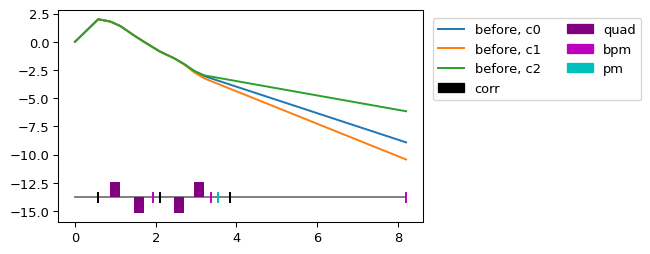

In [13]:
r0 = []
for fm_vm in fm_vms:
    r,s = fm_vm.fm.run(monitor='all',to_element=fm_vm.last_elem_index)
    r0.append( fm_vm.fm.collect_data(r,'pos','xcen','ycen') )

fig,ax = plt.subplots(figsize=(5,3),dpi=94)
for i,r0_ in enumerate(r0):
    ax.plot(r0_['pos'],r0_['xcen'],label='before, c'+str(i))
fm_vm.fm.plot_lattice(end=fm_vm.last_elem_index+1,ax=ax,ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1])

In [14]:
objFuncs._global_machineIO.fetch_data = machineIO_vms[0].fetch_data
objFuncs._global_machineIO.ensure_set = machineIO_vms[0].ensure_set
objFuncs._global_machineIO._test = True

In [15]:
fm_vm.x0

[-15.990100000000002, 11.56861]

In [16]:
res = residuals.residualObjMultiConditionalVar(  
    decision_CSETs = decision_CSETs,
    decision_min= -40,
    decision_max=  40,
    objective_goal = objective_goal,
    objective_norm = objective_norm,
    objective_weight = objective_weight,
    conditional_SETs = conditional_SETs,
    var_obj_weight_fraction = 0.9,
    )

for i in range(n_condition):
    res.residualObj[i].machineIO = machineIO_vms[i]

[condition_controller] ======== class info ========
init_time: 2024-02-06 15:30:48.914594
class_hierarchy: [
    objFuncBase]
decision_CSETs: [
    FS2_BTS:PSQ_D3950:I_CSET, FS2_BTS:PSQ_D3955:I_CSET]
decision_min: [70. 70.]
decision_max: [100. 100.]
decision_bounds: [[ 70 100]
 [ 70 100]]
decision_RDs: [
    FS2_BTS:PSQ_D3950:I_RD, FS2_BTS:PSQ_D3955:I_RD]
decision_tols: None
decision_couplings: None
history_buffer_size: None
logging_frequency: inf
logging_tag: condition_controler
logging_fname: None
x0: [
    0.5, 0.5]

[condition 0] ======== class info ========
init_time: 2024-02-06 15:30:48.954570
class_hierarchy: [
    residualObj, objFuncBase]
decision_CSETs: [
    FS2_BTS:PSC2_D3930:I_CSET, FS2_BTS:PSC2_D3945:I_CSET]
decision_min: [-40. -40.]
decision_max: [40. 40.]
decision_bounds: [[-40.  40.]
 [-40.  40.]]
decision_RDs: [
    FS2_BTS:PSC2_D3930:I_RD, FS2_BTS:PSC2_D3945:I_RD]
decision_tols: None
decision_couplings: None
history_buffer_size: None
logging_frequency: inf
logging_ta

In [17]:
plot0 = plot_obj_history(
    res.residualObj[0].history['decision_CSETs'],
    title='condition0',
)
plot1 = plot_obj_history(
    res.residualObj[1].history['decision_CSETs'],
    title='condition1',
)
plot2 = plot_obj_history(
    res.residualObj[2].history['decision_CSETs'],
    title='condition2',
)
plot_control = plot_obj_history(
    res.condition_controller.history['decision_CSETs'],
    title='condition controller',
)

plot_conditions_RDs = plot_multi_obj_history(
    histories = [res.history['condition'+str(i)]['objective_RDs'] for i in range(n_condition)],
    history_labels = ['C'+str(i) for i in range(n_condition)],
    title='multi-condition_obj_RDs',
)
plot_objectives_var = plot_obj_history(
    res.history['objectives_var'],
    title='objectives_var',
)

class add_delay:
    def __init__(self):
        pass
    def __call__(self):
        time.sleep(0.1)
    def close(self):
        pass
    
add_delay = add_delay()
    
callbacks = [add_delay,plot0,plot1,plot2,plot_control,plot_conditions_RDs,plot_objectives_var,add_delay]
# callbacks = []

In [18]:
def func_obj(x,callbacks=callbacks):
    if x.ndim == 2:
        multi_batch = True
    else:
        multi_batch = False
    obsvars = res(x,multi_batch=multi_batch,callbacks=callbacks)
    if multi_batch:
        return 1-np.mean(obsvars**2,axis=1)
    else:
        return 1-np.mean(obsvars**2)

scipy version mismatch. 'scipy.stat.qmc' is not imported. Using custom halton seqeunce instead


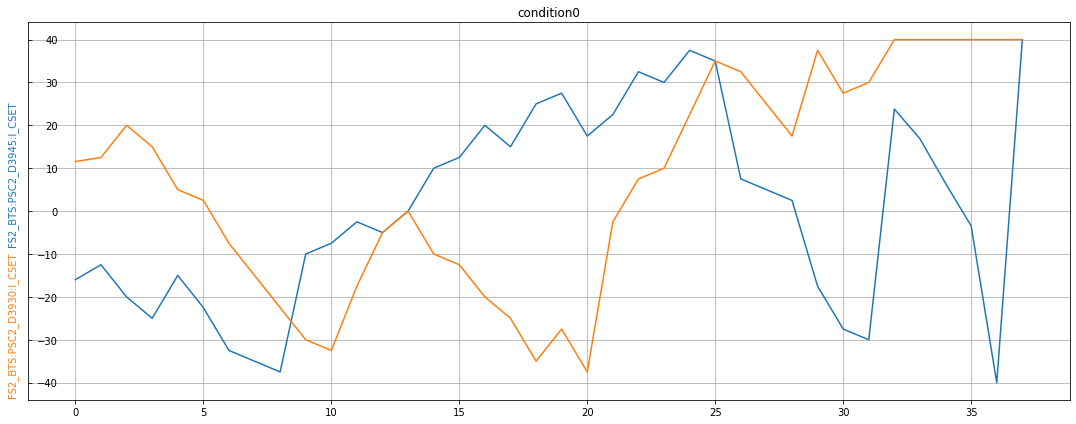

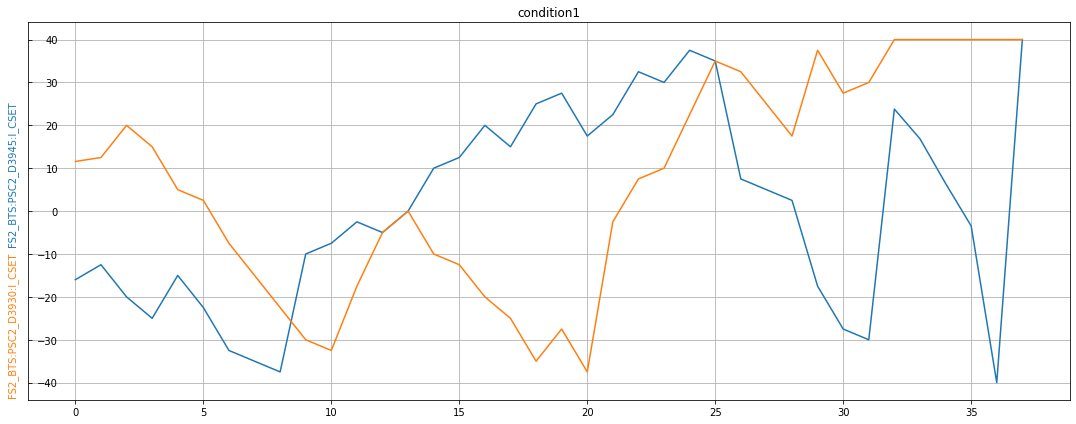

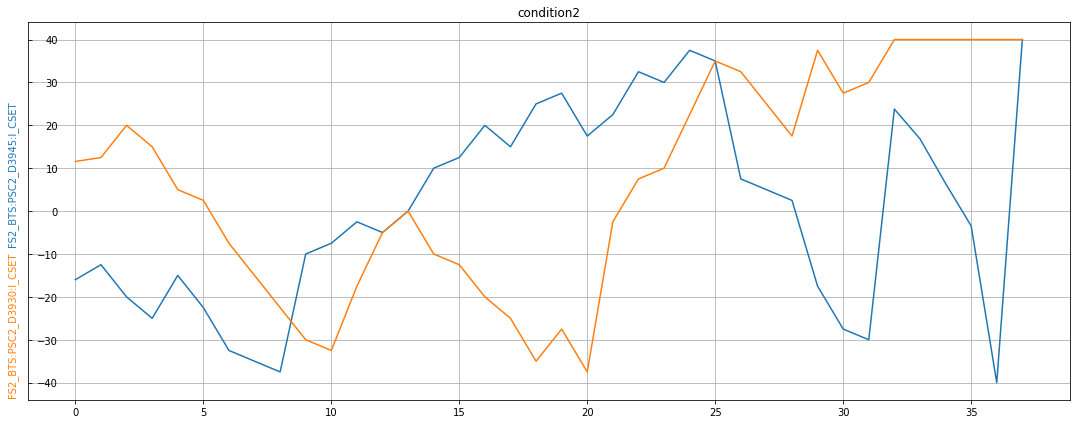

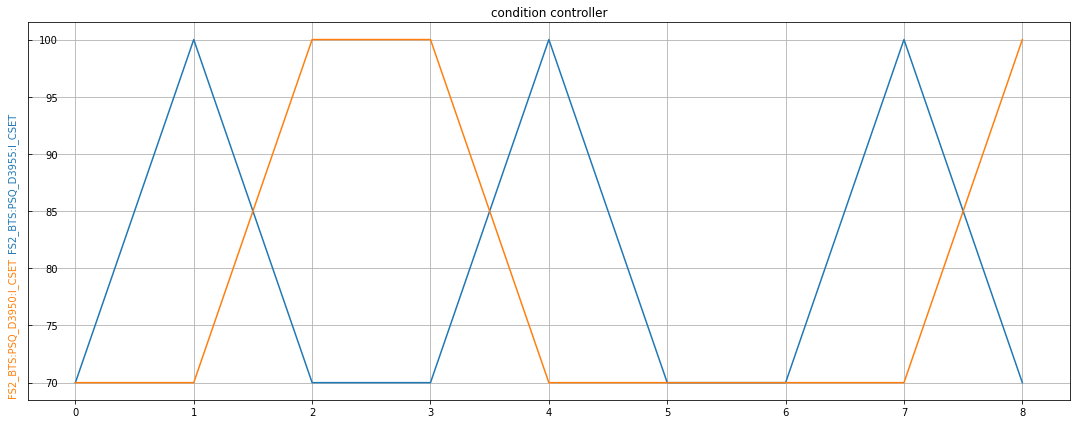

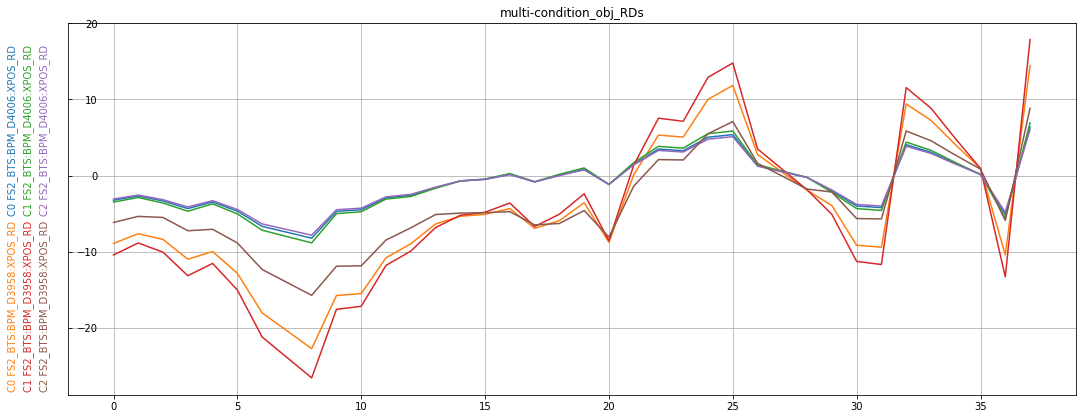

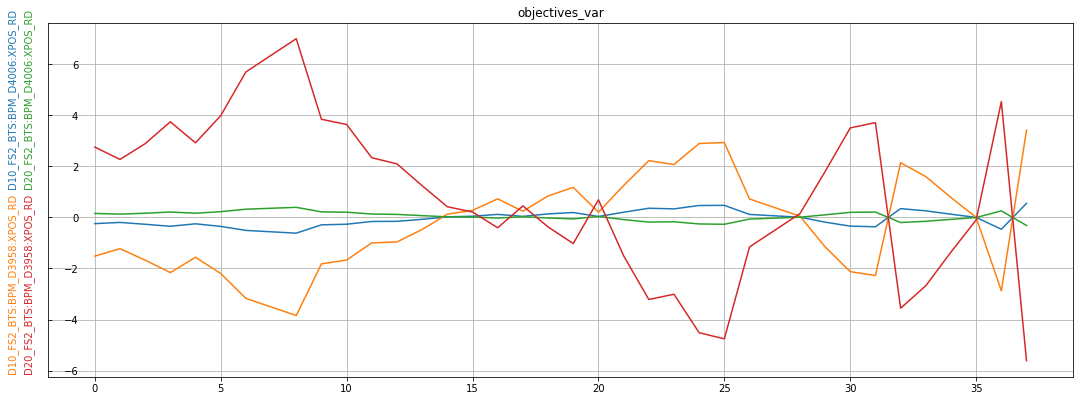

9.0


In [19]:
bo, X_pending, Y_pending_future = pyBO.runBO(
    func_obj = func_obj,
    bounds=res.decision_bounds,
    n_init=n_init,
    budget=budget-batch_size*n_loop,
    isfunc_obj_batched=True,
    batch_size=batch_size,
    x0=res.x0,
    timeout = 2*batch_size,
)

betas = np.linspace(9,1,n_loop)
for i in range(n_loop):
    beta = betas[i]
    print(beta)
    if bo.best_sofar()[1] > 0.95:
        break
    acquisition_func_args = {'beta':beta}
    X_pending, Y_pending_future = bo.loop(
        n_loop = 1,
        func_obj = func_obj,
        isfunc_obj_batched = True,
        bounds=res.decision_bounds,
        acquisition_func_args=acquisition_func_args,
        X_pending = X_pending,
        Y_pending_future = Y_pending_future,
        batch_size = batch_size,
        write_log = False,
        timeout = 2*batch_size,
    )
for f in callbacks:
    f.close()

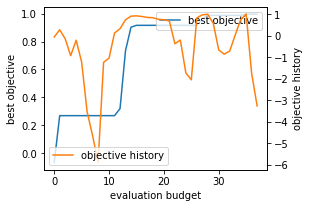

In [20]:
bo.plot_obj_history()
ax.vlines(n_init,*ax.get_ylim(),color='k')

In [21]:
x_best,y_best_old = bo.best_sofar()
y_best_new = func_obj(x_best,callbacks=None)
print(x_best,y_best_old[0],y_best_new)

[-3.46063909 40.        ] 0.9966506348167261 0.9966506348167261


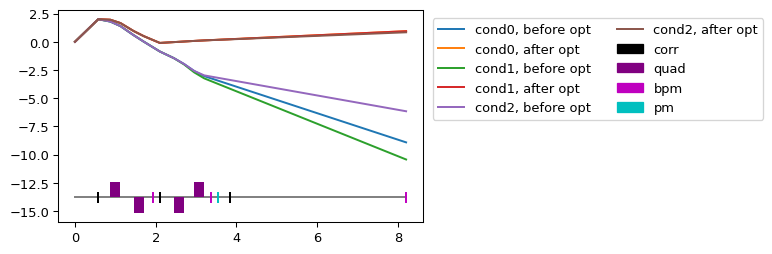

In [22]:
r1 = []
for fm_vm in fm_vms:
    r,s = fm_vm.fm.run(monitor='all',to_element=fm_vm.last_elem_index)
    r1.append( fm_vm.fm.collect_data(r,'pos','xcen','ycen') )

fig,ax = plt.subplots(figsize=(5,3),dpi=94)
i=0
for r0_, r1_ in zip(r0,r1):
    ax.plot(r0_['pos'],r0_['xcen'],label='cond'+str(i)+', before opt')
    ax.plot(r1_['pos'],r1_['xcen'],label='cond'+str(i)+', after opt')
    i+=1
fm_vm.fm.plot_lattice(end=fm_vm.last_elem_index+1,ax=ax,ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1])